# Variational Distribution Learning (VDL) 


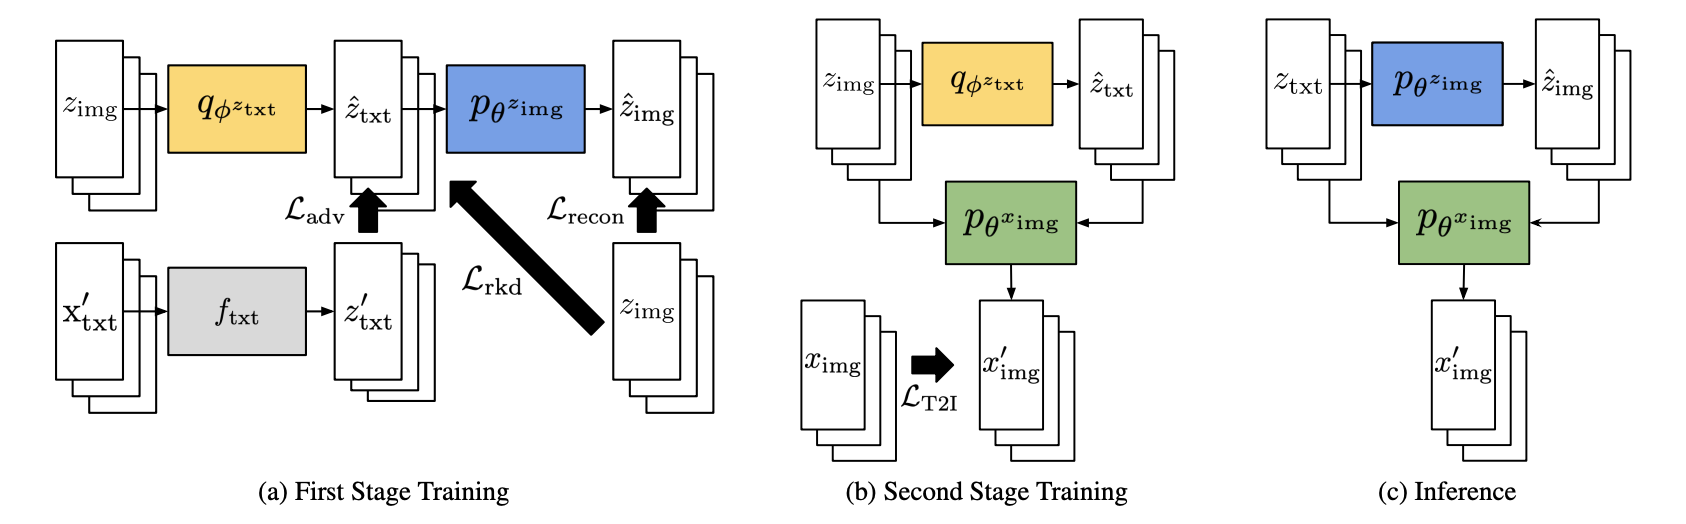

In [4]:
from IPython.display import Image
Image(filename='imgs/VDL_Framework.png', width=900)


>## Stage 1 Training

> * we fix the T2I model parameters while training other parameters, which is equivalent to solve the following optimization. 


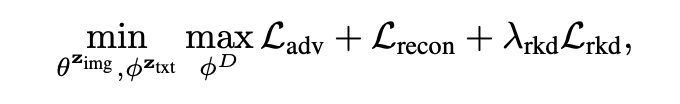

In [7]:
Image(filename='imgs/VDL_Stage1.png', width=500)



 >## Stage 2 Training 
> * we train the T2I model parameters while fixing other parameters, which is equivalent to solve the following optimization. 
>> * In case of using GAN frameworks for the T2I model, we replace the conditional log-likelihood with the adversarila loss.


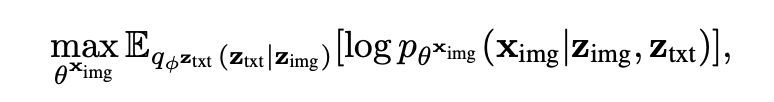

In [8]:
Image(filename='imgs/VDL_Stage2.png', width=500)

>## Inferece
> * Given the text sentence input, we first obtain its embedding using the pre-trained CLIP text encoder. 
> * Then, we draw a CLIP image embedding sample 
> * Finally, we obtain an image using a T2I model based on the two CLIP embedding samples

# 1. Implementation of Stage1

## 1.1 GAN Loss 


> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake.

THe adversarial loss for the discriminator is expressed as below

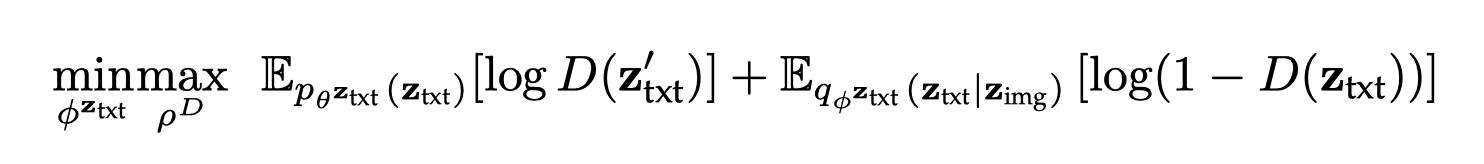

In [11]:
Image(filename='imgs/VDL_Stage1_Adv_Loss.png', width=700)

THe adversarial loss for the generator is expressed as below

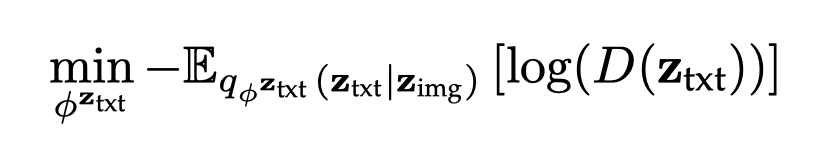

In [16]:
Image(filename='imgs/VDL_Stage1_Adv_Loss_Gen.png', width=400)

### Let's design Logistic loss!

> **Exercise**: Create a logistic loss using the above equation. 

In [14]:
import torch.nn.functional as F
def discriminator_logistic_loss(D_logit_real, D_logit_fake): 
    # D_logit_real: Discriminator output of the prior samples drawn from p(z_txt)
    # D_logit_fake: Discriminator output of the variational samples drawn from q(z_txt|z_img)
    loss_dis = torch.mean(F.softplus(-D_logit_real)) + torch.mean(F.softplus(D_logit_fake))
    
    return loss_dis
    
def discriminator_loss_for_fake(D_logit_fake):
    loss_gen = F.softplus(-D_logit_fake).mean()
    return loss_gen

In addition to the logistic loss, we add R1 regularization for Discrimnator, where the objective is widely adopted for training instability, which is given by

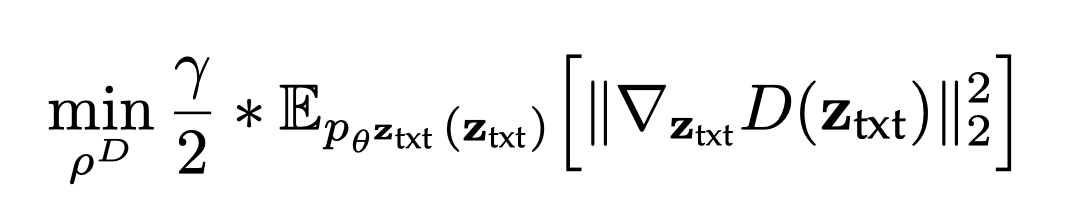

In [18]:
Image(filename='imgs/VDL_Stage1_R1.png', width=400)

In [ ]:
def R1_regularization(Discriminator, prior_samples, gamma):
    # prior_samples: samples of p(z_txt)
    prior_samples.requires_grad_(True)
    D_logit_real = Discriminator(prior_samples) 
    r1_grads = torch.autograd.grad(ouputs=[D_logit_real.sum()], inputs=[prior_samples], create_graph=True, only_inputs=True)[0]
    r1_grads_2norm_square = r1_grads**2.square().sum(-1)
    loss_D_r1 = r1_grads_2norm_square.mean() * 0.5 * gamma
    return loss_D_r1
    

## 1.2 Reconstruction Loss 


> * The loss encourages the reconstruction of the variational samples via the deooder become close to the observed CLIP image embedding samples.

Let's design the reconstruction loss based on L2 loss 

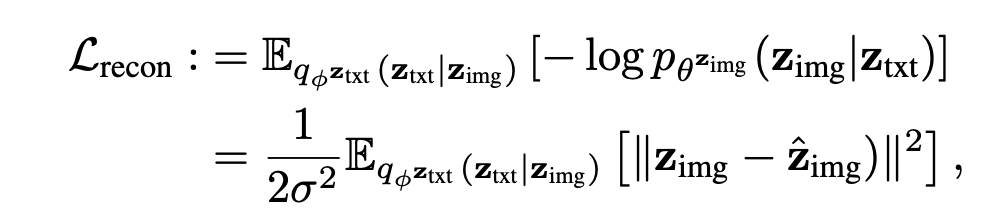

In [20]:
Image(filename='./imgs/VDL_Stage1_Recon_Loss.png', width=500)

In the above equation, we draw a sample \hat{z}_img using the following equation

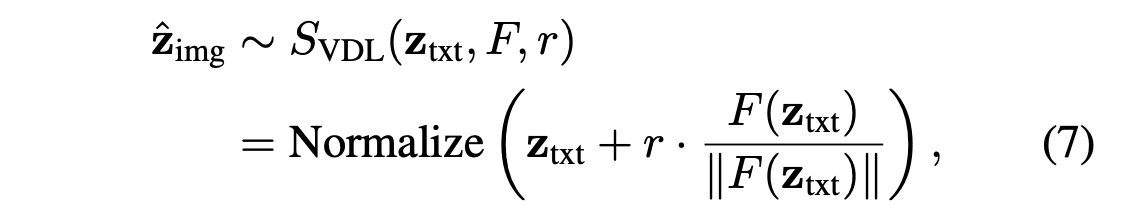

In [22]:
Image(filename='imgs/VDL_CLIP_img_recon.png', width=500)

### Let's design the reconstruction loss!

> **Exercise**: Create a reconstruction loss using the above equation.

In [15]:
 def recon_loss(z_img, variational_z_txt, decoder, sigma, r):
    F_z_txt = decoder(variational_z_txt)
    z_img_recon_samples = z_txt + r * F_z_txt/F_z_txt.norm(dim=-1, keepdim=True)  
    z_img_recon_samples /= z_img_recon_samples.norm(dim=-1, keepdim=True) # Normalize
    
    loss_recon = (1/sigma**2) * torch.mean((z_img - z_img_recon_samples)**2.sum(1))
    return loss_cycle

## 1.3 Relational Knowledge Distillation (RKD) Loss 


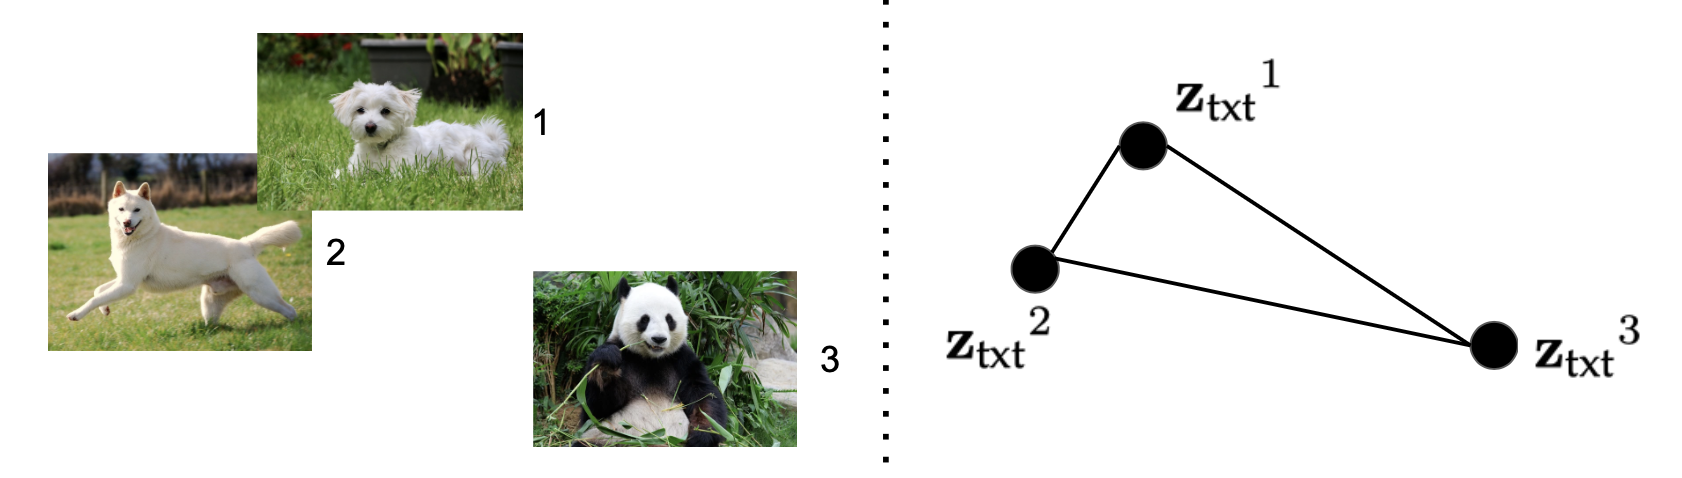

In [24]:
Image(filename='imgs/VDL_RKD_figure.png', width=900)

> * We encourage the variational text samples z_txt to mimic the correlation of the observed image embedding samples z_img in order to mitigate the challenge posed by the lack of supervision.
> * The relational knowledge distillation loss is defined as follows: 

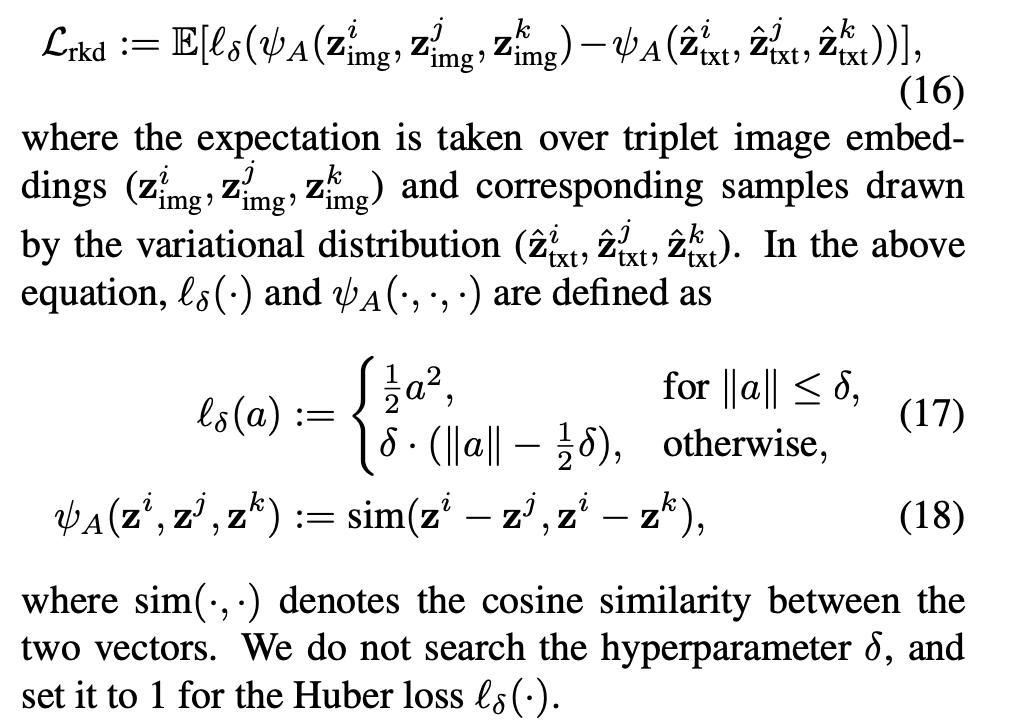

In [26]:
Image(filename='imgs/VDL_RKD_detail.png', width=600)

### Let's design the RKD loss!

> **Exercise**: Create the RKD loss using the above equation.

In [27]:
def RKDLoss(zs_img, zs_txt):
    with torch.no_grad():
        # zs_img size: (N,D)
        zs_img_diff = zs_img.unsqueeze(0) - zs_img.unsqueeze(1)
        # (1, N, D) - (N, 1, D) = N, N, D
        #zs_img_diff: (N,N,D)
        zs_img_diff_norm = F.normalize(zs_img_diff, p=2, dim=2)  # (N, N, D) 
        psi_angle_zs_img_diff = torch.bmm(zs_img_diff_norm, zs_img_diff_norm.transpose(1, 2)) # [N, N^2]
        psi_angle_zs_img_diff = psi_angle_zs_img_diff.view(-1) # [N^3, 1] 
        
            
    zs_txt_diff = zs_txt.unsqueeze(0) - zs_txt.unsqueeze(1)
    # [N, N,D]
    zs_txt_diff_norm = F.normalize(zs_txt_diff, p=2, dim=2)
    psi_angle_zs_txt_diff = torch.bmm(zs_txt_diff_norm, zs_txt_diff_norm.transpose(1, 2)).view(-1) 
    # [N**3, 1]

    loss_rkd = F.smooth_l1_loss(psi_angle_zs_txt_diff, psi_angle_zs_img_diff, reduction="elementwise_mean") # Huber Loss
    return loss_rkd